数据列名: ['时间(min)', '乙醇转化率(%)', '乙烯选择性(%)', 'C4烯烃选择性(%)', '乙醛选择性(%)', '碳数为4-12脂肪醇选择性(%)', '甲基苯甲醛和甲基苯甲醇选择性(%)', '其他选择性(%)']
数据形状: (7, 8)
前几行数据:
   时间(min)   乙醇转化率(%)  乙烯选择性(%)  C4烯烃选择性(%)  乙醛选择性(%)  碳数为4-12脂肪醇选择性(%)  \
0       20  43.547389      4.23       39.90      5.17             39.70   
1       70  37.788146      4.28       38.55      5.60             37.36   
2      110  36.556360      4.46       36.72      6.37             32.39   
3      163  32.721857      4.63       39.53      7.82             31.29   
4      197  31.710097      4.62       38.96      8.19             31.49   

   甲基苯甲醛和甲基苯甲醇选择性(%)  其他选择性(%)  
0               2.58      8.42  
1               4.28      9.93  
2               4.63     15.43  
3               4.80     11.93  
4               4.26     12.48  
=== 问题1改进版：催化剂失活动力学分析 ===
数据点数量: 7
时间范围: 20 - 273 min
可用的列: ['时间(min)', '乙醇转化率(%)', '乙烯选择性(%)', 'C4烯烃选择性(%)', '乙醛选择性(%)', '碳数为4-12脂肪醇选择性(%)', '甲基苯甲醛和甲基苯甲醇选择性(%)', '其他选择性(%)', 'C4烯烃收率']
将要分析的指标: ['乙醇转化率', 'C4烯烃选

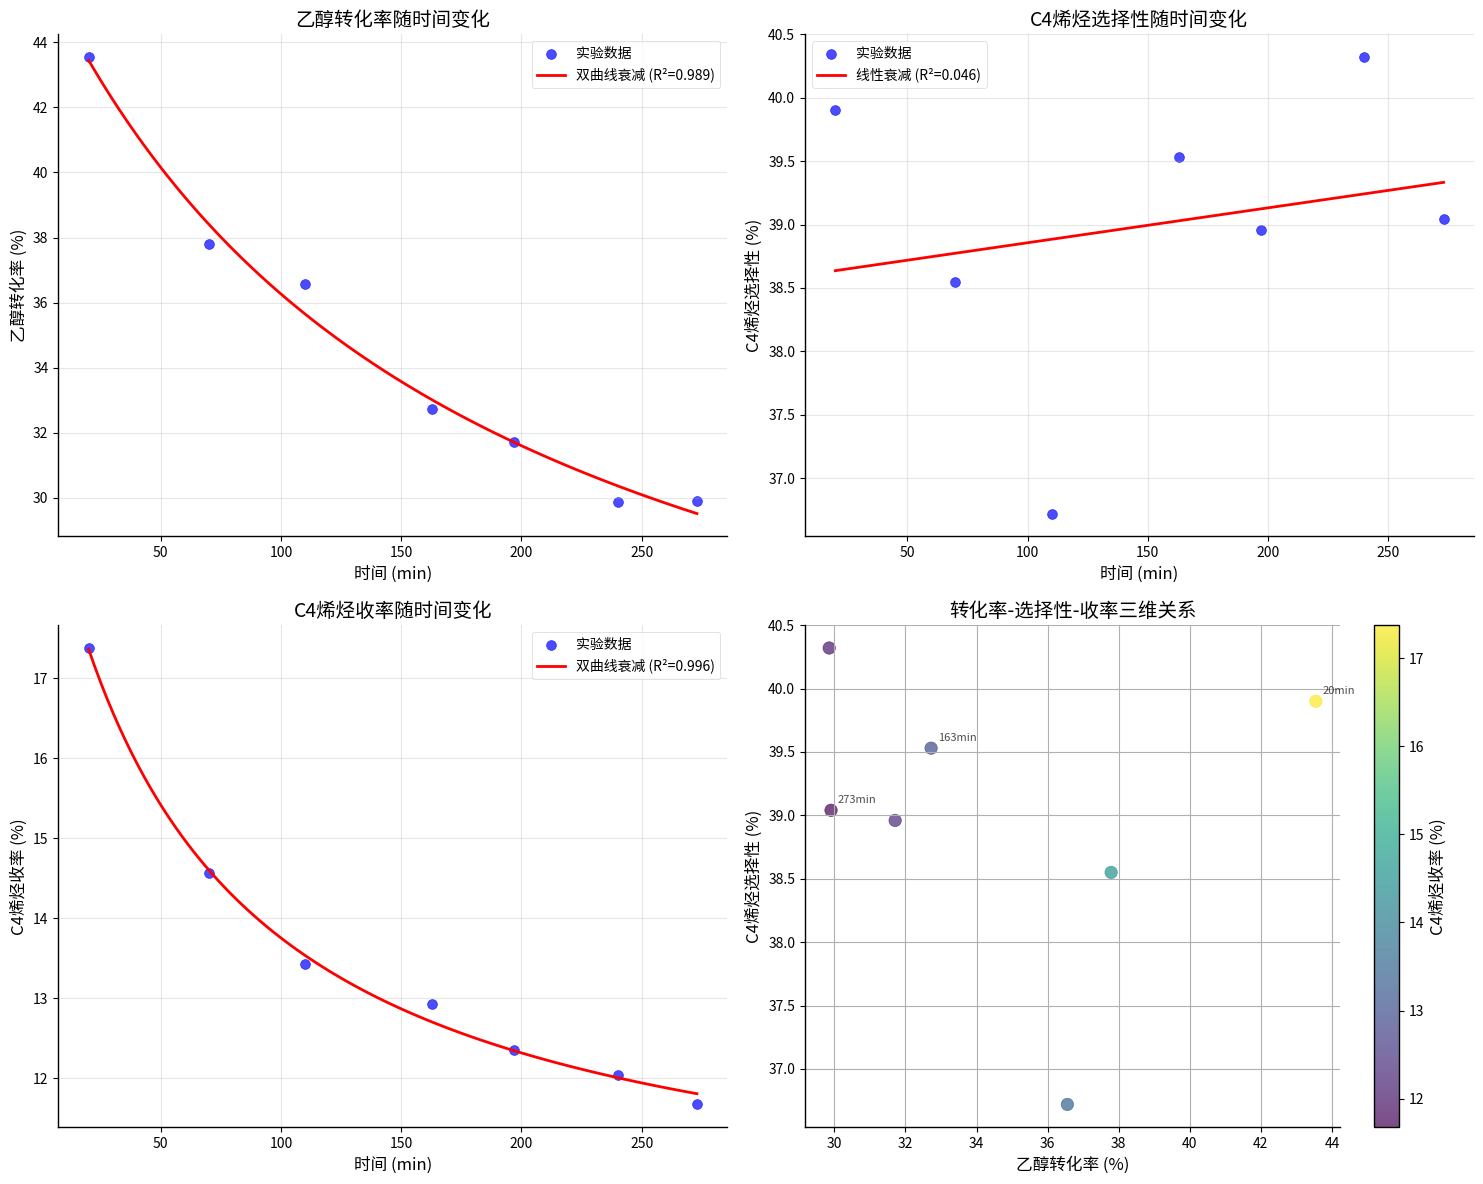


=== 催化剂失活机理分析 ===
各指标与时间的相关性:
乙醇转化率(%): r = -0.966
C4烯烃选择性(%): r = 0.215
C4烯烃收率: r = -0.926

失活机理推断:

乙醇转化率:
  最佳模型: 双曲线衰减
  机理推断: 催化剂失活涉及可逆过程
  可能原因: 活性位点的可逆吸附或表面重构

C4烯烃选择性:
  最佳模型: 线性衰减
  机理推断: 催化剂活性位点数量线性减少
  可能原因: 毒化、烧结或载体结构破坏

C4烯烃收率:
  最佳模型: 双曲线衰减
  机理推断: 催化剂失活涉及可逆过程
  可能原因: 活性位点的可逆吸附或表面重构

=== 催化剂寿命预测 ===
乙醇转化率:
  初始值: 43.55%
  600分钟预测值: 24.99%
  活性保持率: 57.4%
C4烯烃选择性:
  初始值: 39.90%
  600分钟预测值: 40.23%
  活性保持率: 100.8%
C4烯烃收率:
  初始值: 17.38%
  600分钟预测值: 10.90%
  活性保持率: 62.7%

=== 分析结果汇总 ===
     指标  最佳模型       R²                                拟合方程   与时间相关系数
  乙醇转化率 双曲线衰减 0.988638 y = 27.479/(1 + 0.005736t) + 18.801 -0.965880
C4烯烃选择性  线性衰减 0.046419              y = 0.002754t + 38.581  0.215450
 C4烯烃收率 双曲线衰减 0.996265   y = 9.707/(1 + 0.015613t) + 9.964 -0.926002
分析结果已保存

=== 分析结论 ===
1. 催化剂失活动力学模型已建立
2. 各指标的失活机理已分析
3. 催化剂寿命预测已完成
4. 结果已保存至 'results/问题1/催化剂失活动力学分析结果.csv'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
import os
warnings.filterwarnings('ignore')


# 确保结果文件夹存在
os.makedirs('results/问题1', exist_ok=True)

# 读取350°C稳定性数据
df2 = pd.read_csv('data/附件2.csv')

# 检查数据结构
print("数据列名:", df2.columns.tolist())
print("数据形状:", df2.shape)
print("前几行数据:")
print(df2.head())

df2['C4烯烃收率'] = df2['乙醇转化率(%)'] * df2['C4烯烃选择性(%)'] / 100

print("=== 问题1改进版：催化剂失活动力学分析 ===")
print(f"数据点数量: {len(df2)}")
print(f"时间范围: {df2['时间(min)'].min():.0f} - {df2['时间(min)'].max():.0f} min")

# 1. 催化剂失活动力学模型定义
def exponential_decay(t, A0, k, C):
    """指数衰减模型: A(t) = A0 * exp(-k*t) + C"""
    return A0 * np.exp(-k * t) + C

def power_law_decay(t, A0, k, n, C):
    """幂律衰减模型: A(t) = A0 * (1 + k*t)^(-n) + C"""
    return A0 * (1 + k * t)**(-n) + C

def hyperbolic_decay(t, A0, k, C):
    """双曲线衰减模型: A(t) = A0 / (1 + k*t) + C"""
    return A0 / (1 + k * t) + C

# 2. 时间序列拟合分析函数
def analyze_time_series(time_data, activity_data, indicator_name):
    """
    对时间序列数据进行多种动力学模型拟合
    """
    results = {}
    
    # 线性衰减模型
    try:
        slope, intercept, r_value, p_value, std_err = stats.linregress(time_data, activity_data)
        linear_pred = slope * time_data + intercept
        linear_r2 = r_value**2
        
        results['线性衰减'] = {
            'params': [slope, intercept],
            'r2': linear_r2,
            'pred': linear_pred,
            'equation': f'y = {slope:.6f}t + {intercept:.3f}',
            'slope': slope,
            'p_value': p_value
        }
    except:
        results['线性衰减'] = None
    
    # 指数衰减模型
    try:
        # 估计初始参数
        A0_guess = activity_data[0] - activity_data[-1]
        k_guess = 0.001
        C_guess = activity_data[-1]
        
        popt, _ = curve_fit(exponential_decay, time_data, activity_data, 
                           p0=[A0_guess, k_guess, C_guess],
                           bounds=([0, 0, 0], [np.inf, 1, np.inf]),
                           maxfev=5000)
        
        exp_pred = exponential_decay(time_data, *popt)
        exp_r2 = r2_score(activity_data, exp_pred)
        
        results['指数衰减'] = {
            'params': popt,
            'r2': exp_r2,
            'pred': exp_pred,
            'equation': f'y = {popt[0]:.3f}exp(-{popt[1]:.6f}t) + {popt[2]:.3f}',
            'half_life': np.log(2) / popt[1] if popt[1] > 0 else np.inf
        }
    except:
        results['指数衰减'] = None
    
    # 双曲线衰减模型
    try:
        A0_guess = activity_data[0] * (1 + 0.001 * time_data[-1])
        k_guess = 0.001
        C_guess = min(activity_data) * 0.5
        
        popt, _ = curve_fit(hyperbolic_decay, time_data, activity_data,
                           p0=[A0_guess, k_guess, C_guess],
                           bounds=([0, 0, 0], [np.inf, 1, np.inf]),
                           maxfev=5000)
        
        hyp_pred = hyperbolic_decay(time_data, *popt)
        hyp_r2 = r2_score(activity_data, hyp_pred)
        
        results['双曲线衰减'] = {
            'params': popt,
            'r2': hyp_r2,
            'pred': hyp_pred,
            'equation': f'y = {popt[0]:.3f}/(1 + {popt[1]:.6f}t) + {popt[2]:.3f}'
        }
    except:
        results['双曲线衰减'] = None
    
    # 选择最佳模型
    valid_models = {k: v for k, v in results.items() if v is not None and v['r2'] > 0}
    if valid_models:
        best_model = max(valid_models.items(), key=lambda x: x[1]['r2'])
        results['最佳模型'] = best_model
    else:
        results['最佳模型'] = None
    
    return results

# 执行时间序列分析
time_data = df2['时间(min)'].values

# 检查并创建正确的指标映射
available_columns = df2.columns.tolist()
print("可用的列:", available_columns)

# 动态创建indicators字典，基于实际的列名
indicators = {}
if '乙醇转化率(%)' in available_columns:
    indicators['乙醇转化率'] = df2['乙醇转化率(%)'].values
if 'C4烯烃选择性(%)' in available_columns:
    indicators['C4烯烃选择性'] = df2['C4烯烃选择性(%)'].values
if 'C4烯烃收率' in available_columns:
    indicators['C4烯烃收率'] = df2['C4烯烃收率'].values

print("将要分析的指标:", list(indicators.keys()))

analysis_results = {}
for indicator_name, activity_data in indicators.items():
    print(f"\n--- {indicator_name}时间序列分析 ---")
    results = analyze_time_series(time_data, activity_data, indicator_name)
    analysis_results[indicator_name] = results
    
    # 输出分析结果
    for model_name, result in results.items():
        if model_name != '最佳模型' and result is not None:
            print(f"{model_name}: R² = {result['r2']:.4f}")
            print(f"  方程: {result['equation']}")
            if model_name == '线性衰减':
                slope_per_hour = result['slope'] * 60  # 转换为每小时变化率
                print(f"  衰减速率: {slope_per_hour:.4f} %/h")
                if result['p_value'] < 0.05:
                    print(f"  显著性: p = {result['p_value']:.4f} (显著)")
                else:
                    print(f"  显著性: p = {result['p_value']:.4f} (不显著)")
            elif model_name == '指数衰减':
                print(f"  半衰期: {result['half_life']:.1f} min")
    
    if results['最佳模型']:
        best_name, best_result = results['最佳模型']
        print(f"最佳模型: {best_name} (R² = {best_result['r2']:.4f})")

# 4. 创建综合可视化分析
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# 为每个指标绘制时间序列及拟合曲线
for idx, (indicator_name, activity_data) in enumerate(indicators.items()):
    ax = axes[idx]
    
    # 绘制原始数据
    ax.scatter(time_data, activity_data, alpha=0.7, s=50, label='实验数据', color='blue')
    
    # 绘制最佳拟合曲线
    results = analysis_results[indicator_name]
    if results['最佳模型']:
        best_name, best_result = results['最佳模型']
        
        # 创建更密集的时间点用于绘制拟合曲线
        t_fit = np.linspace(time_data.min(), time_data.max(), 100)
        
        if best_name == '线性衰减':
            y_fit = best_result['params'][0] * t_fit + best_result['params'][1]
        elif best_name == '指数衰减':
            y_fit = exponential_decay(t_fit, *best_result['params'])
        elif best_name == '双曲线衰减':
            y_fit = hyperbolic_decay(t_fit, *best_result['params'])
        
        ax.plot(t_fit, y_fit, 'r-', linewidth=2, 
                label=f'{best_name} (R²={best_result["r2"]:.3f})')
    
    ax.set_title(f'{indicator_name}随时间变化')
    ax.set_xlabel('时间 (min)')
    ax.set_ylabel(f'{indicator_name} (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 第四个子图：收率vs转化率vs选择性关系
ax = axes[3]
scatter = ax.scatter(df2['乙醇转化率(%)'], df2['C4烯烃选择性(%)'], 
                    c=df2['C4烯烃收率'], cmap='viridis', s=80, alpha=0.7)
ax.set_xlabel('乙醇转化率 (%)')
ax.set_ylabel('C4烯烃选择性 (%)')
ax.set_title('转化率-选择性-收率三维关系')
plt.colorbar(scatter, ax=ax, label='C4烯烃收率 (%)')

# 添加时间标注
for i, time_point in enumerate(df2['时间(min)']):
    if i % 3 == 0:  # 每隔3个点标注一次，避免过于密集
        ax.annotate(f'{time_point:.0f}min', 
                   (df2['乙醇转化率(%)'].iloc[i], df2['C4烯烃选择性(%)'].iloc[i]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

plt.tight_layout()
plt.savefig(f'results/问题1/催化剂失活动力学分析.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. 失活机理分析
print(f"\n=== 催化剂失活机理分析 ===")

# 动态创建相关性矩阵的列名列表
corr_columns = ['时间(min)']
if '乙醇转化率(%)' in df2.columns:
    corr_columns.append('乙醇转化率(%)')
if 'C4烯烃选择性(%)' in df2.columns:
    corr_columns.append('C4烯烃选择性(%)')
if 'C4烯烃收率' in df2.columns:
    corr_columns.append('C4烯烃收率')

# 计算各指标的相关性
correlation_matrix = df2[corr_columns].corr()
print("各指标与时间的相关性:")
time_correlations = correlation_matrix.loc['时间(min)'].drop('时间(min)')
for indicator, corr in time_correlations.items():
    print(f"{indicator}: r = {corr:.3f}")

# 基于最佳模型推断失活机理
print(f"\n失活机理推断:")
for indicator_name, results in analysis_results.items():
    if results['最佳模型']:
        best_name, best_result = results['最佳模型']
        print(f"\n{indicator_name}:")
        print(f"  最佳模型: {best_name}")
        
        if best_name == '线性衰减':
            print(f"  机理推断: 催化剂活性位点数量线性减少")
            print(f"  可能原因: 毒化、烧结或载体结构破坏")
        elif best_name == '指数衰减':
            print(f"  机理推断: 催化剂失活遵循一级动力学")
            print(f"  可能原因: 积炭覆盖活性位点或热烧结")
            print(f"  特征时间: {best_result['half_life']:.1f} min")
        elif best_name == '双曲线衰减':
            print(f"  机理推断: 催化剂失活涉及可逆过程")
            print(f"  可能原因: 活性位点的可逆吸附或表面重构")

# 6. 催化剂寿命预测
print(f"\n=== 催化剂寿命预测 ===")
for indicator_name, results in analysis_results.items():
    if results['最佳模型']:
        best_name, best_result = results['最佳模型']
        
        # 预测600分钟时的性能
        t_pred = 600
        if best_name == '线性衰减':
            y_pred = best_result['params'][0] * t_pred + best_result['params'][1]
        elif best_name == '指数衰减':
            y_pred = exponential_decay(t_pred, *best_result['params'])
        elif best_name == '双曲线衰减':
            y_pred = hyperbolic_decay(t_pred, *best_result['params'])
        
        # 确保使用正确的初始值
        if indicator_name in indicators:
            initial_value = indicators[indicator_name][0]
            retention_rate = (y_pred / initial_value) * 100
            
            print(f"{indicator_name}:")
            print(f"  初始值: {initial_value:.2f}%")
            print(f"  600分钟预测值: {y_pred:.2f}%")
            print(f"  活性保持率: {retention_rate:.1f}%")

# 7. 保存分析结果
# 动态创建列名映射字典
column_name_mapping = {}
if '乙醇转化率' in indicators:
    column_name_mapping['乙醇转化率'] = '乙醇转化率(%)'
if 'C4烯烃选择性' in indicators:
    column_name_mapping['C4烯烃选择性'] = 'C4烯烃选择性(%)'
if 'C4烯烃收率' in indicators:
    column_name_mapping['C4烯烃收率'] = 'C4烯烃收率'

summary_results = []
for indicator_name, results in analysis_results.items():
    if results['最佳模型'] and indicator_name in column_name_mapping:
        best_name, best_result = results['最佳模型']
        # 使用映射获取正确的列名
        corr_column_name = column_name_mapping[indicator_name]
        summary_results.append({
            '指标': indicator_name,
            '最佳模型': best_name,
            'R²': best_result['r2'],
            '拟合方程': best_result['equation'],
            '与时间相关系数': correlation_matrix.loc['时间(min)', corr_column_name]
        })

summary_df = pd.DataFrame(summary_results)
if len(summary_results) > 0:
    print("\n=== 分析结果汇总 ===")
    print(summary_df.to_string(index=False))
    summary_df.to_csv('results/问题1/催化剂失活动力学分析结果.csv', encoding='utf-8-sig', index=False)
    print("分析结果已保存")
else:
    print("无有效的分析结果可保存")

print("\n=== 分析结论 ===")
print("1. 催化剂失活动力学模型已建立")
print("2. 各指标的失活机理已分析")
print("3. 催化剂寿命预测已完成")
print("4. 结果已保存至 'results/问题1/催化剂失活动力学分析结果.csv'")